# Entrenamiento del modelo usando Mini-Batch Gradient Descent
- Utilizaremos el algoritmo de Descenso del Gradiente por mini-lotes.
- Este es el tercero de tres algoritmos que usaremos para efectuar versiones alternativas del entrenamiento:
    1. ✅ GD por lotes (logreg_train.ipynb)
    2. ✅ SGD (logreg_sgd_train.ipynb)
    3. ✅ Mini-Batch GD (logreg_minibatch_train.ipynb) 

Las principales características del Mini-Batch GD son:

1. Diferencias con GD por lotes:
   - Procesa subconjuntos de datos (mini-batches) en vez de todo el dataset
   - Actualiza los pesos más frecuentemente (después de cada mini-batch)
   - Converge más rápido que el GD por lotes

2. Diferencias con SGD:
   - Más estable que SGD (usa más muestras por actualización)
   - Mejor estimación del gradiente que SGD
   - Puede aprovechar mejor la vectorización

3. Parámetros clave:
   - batch_size: típicamente 32, 64, 128, 256 (potencias de 2)
   - Más pequeño → más cerca de SGD
   - Más grande → más cerca de GD por lotes

4. Ventajas del Mini-Batch GD:
   - Balance entre velocidad y estabilidad
   - Mejor uso de la memoria caché y vectorización
   - Menos varianza en las actualizaciones que SGD

Iniciando entrenamiento con Descenso de Gradiente Mini-Batch...
Coste inicial: 1.37283398052185
Época 0: Coste = 0.28408396333976005
Época 10: Coste = 0.12402019941578712
Época 20: Coste = 0.11930939758200355
Época 30: Coste = 0.11587286543120183
Época 40: Coste = 0.11432905353116525
Época 50: Coste = 0.11326088775148799
Época 60: Coste = 0.1124354488560144
Época 70: Coste = 0.11176379541767535
Época 80: Coste = 0.11120243275388528
Época 90: Coste = 0.11077498967388895


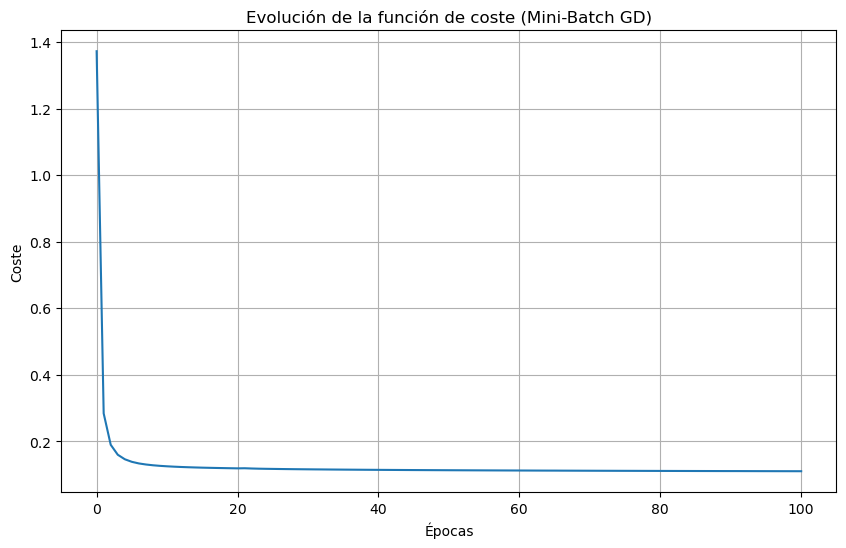


Precisión del modelo: 0.9831


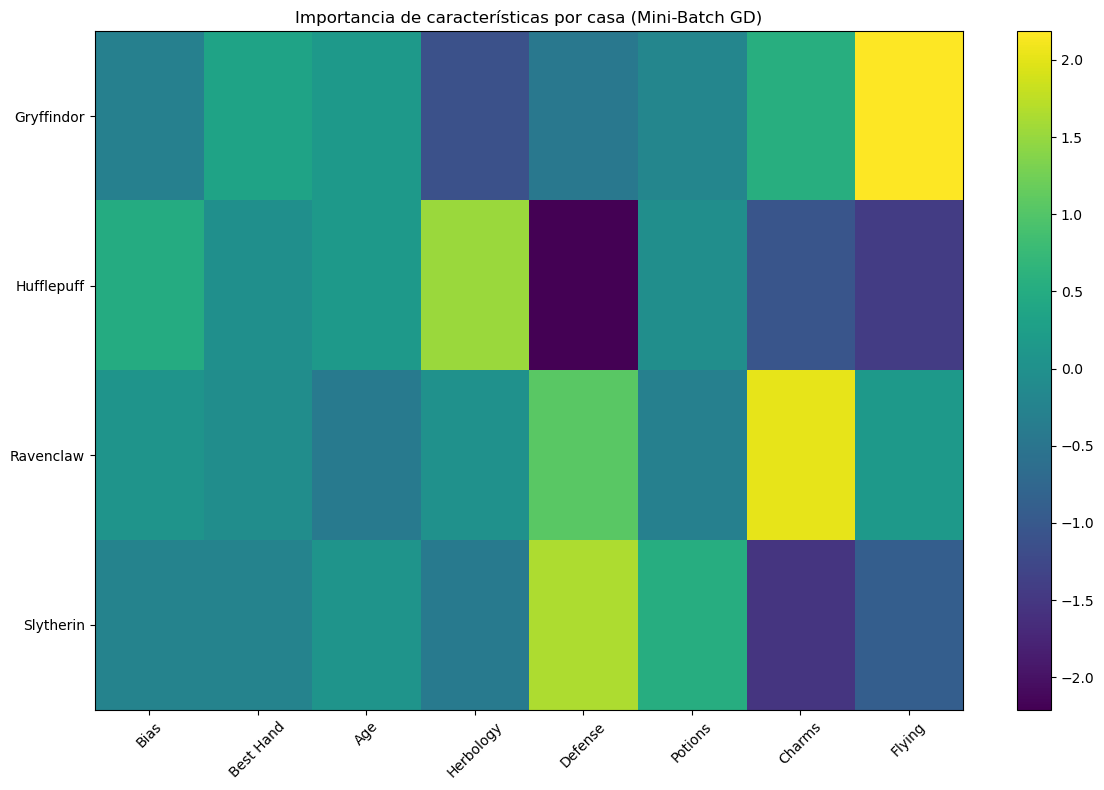

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

### Leemos el DataSet de entrenamiento normalizado
df = pd.read_csv('../datasets/normal_train.csv')

### Variables del modelo
# 1. Crear la matriz y con todas las casas ya que estamos en un caso de clasificación multinomial
y = df[['House_Gryffindor', 'House_Hufflepuff', 'House_Ravenclaw', 'House_Slytherin']]

# 2. Seleccionar las características (X)
X = df[['Best Hand', 'Age', 'Herbology', 'Defense Against the Dark Arts',
        'Potions', 'Charms', 'Flying']]

# 3. Agregar columna de 1's para el término de sesgo (bias)
X = np.c_[np.ones(len(X)), X]

# Convertir a arrays de numpy para operaciones más eficientes
X = np.array(X)
y = np.array(y)

### Función Softmax (igual que antes)
def softmax(z):
    """
    Calcula la función softmax para clasificación multinomial
    """
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_scores = np.exp(z_shifted)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

### Función de pérdida (igual que antes)
def compute_cost(X, y, W):
    """
    Calcula la función de pérdida logarítmica (cross-entropy) para clasificación multinomial
    """
    m = X.shape[0]
    z = np.dot(X, W)
    h = softmax(z)
    epsilon = 1e-15
    return -(1/m) * np.sum(y * np.log(h + epsilon))

### Nueva implementación: Descenso de Gradiente Mini-Batch
def minibatch_gradient_descent(X, y, learning_rate=0.1, num_epochs=100, batch_size=32, epsilon=1e-8):
    """
    Implementa el descenso del gradiente mini-batch para regresión logística multinomial

    Parámetros:
    X: matriz de características (incluyendo columna de 1's)
    y: matriz one-hot de etiquetas reales
    learning_rate: tasa de aprendizaje (alpha)
    num_epochs: número de pasadas completas sobre el dataset
    batch_size: tamaño del mini-batch
    epsilon: umbral para early stopping

    Retorna:
    W: matriz de pesos optimizada
    cost_history: lista con el valor de la función de pérdida
    """
    # Inicializar matriz de pesos W con valores pequeños aleatorios
    n_features = X.shape[1]
    n_classes = y.shape[1]
    W = np.random.randn(n_features, n_classes) * 0.01

    # Número total de muestras
    m = X.shape[0]
    
    # Calcular número de mini-batches por época
    n_batches = int(np.ceil(m / batch_size))
    
    # Lista para guardar el historial de costes
    cost_history = []
    
    # Calcular coste inicial
    current_cost = compute_cost(X, y, W)
    cost_history.append(current_cost)
    print(f'Coste inicial: {current_cost}')

    # Entrenamiento por épocas
    for epoch in range(num_epochs):
        # Mezclar los datos al inicio de cada época
        permutation = np.random.permutation(m)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]
        
        # Mini-batch training
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min(start_idx + batch_size, m)
            
            # Obtener el mini-batch actual
            X_batch = X_shuffled[start_idx:end_idx]
            y_batch = y_shuffled[start_idx:end_idx]
            
            # Calcular predicciones para este mini-batch
            z_batch = np.dot(X_batch, W)
            h_batch = softmax(z_batch)
            
            # Calcular gradiente para este mini-batch
            batch_size_actual = end_idx - start_idx
            gradient = (1/batch_size_actual) * np.dot(X_batch.T, (h_batch - y_batch))
            
            # Actualizar pesos
            W = W - learning_rate * gradient
        
        # Calcular y guardar el coste al final de cada época
        current_cost = compute_cost(X, y, W)
        cost_history.append(current_cost)
        
        # Imprimir progreso cada 10 épocas
        if epoch % 10 == 0:
            print(f'Época {epoch}: Coste = {current_cost}')
            
        # Early stopping
        if epoch > 0 and abs(cost_history[-2] - current_cost) < epsilon:
            print(f'\nConvergencia alcanzada en la época {epoch}')
            print(f'Diferencia en coste: {abs(cost_history[-2] - current_cost)}')
            break
            
    return W, cost_history

# Ejecutar el entrenamiento con Mini-Batch GD
learning_rate = 0.1
num_epochs = 100
batch_size = 32  # Tamaño típico de mini-batch

print("Iniciando entrenamiento con Descenso de Gradiente Mini-Batch...")
W_optimal, cost_history = minibatch_gradient_descent(X, y, learning_rate, num_epochs, batch_size)

# Visualizar la evolución del coste
plt.figure(figsize=(10, 6))
plt.plot(cost_history)
plt.title('Evolución de la función de coste (Mini-Batch GD)')
plt.xlabel('Épocas')
plt.ylabel('Coste')
plt.grid(True)
plt.show()

# Hacer predicciones finales
probabilities = softmax(np.dot(X, W_optimal))
predicted_houses = np.argmax(probabilities, axis=1)
actual_houses = np.argmax(y, axis=1)
accuracy = np.mean(predicted_houses == actual_houses)
print(f"\nPrecisión del modelo: {accuracy:.4f}")

# Visualizar pesos
feature_names = ['Bias', 'Best Hand', 'Age', 'Herbology', 'Defense', 'Potions', 'Charms', 'Flying']
house_names = ['Gryffindor', 'Hufflepuff', 'Ravenclaw', 'Slytherin']

plt.figure(figsize=(12, 8))
plt.imshow(W_optimal.T, aspect='auto')
plt.colorbar()
plt.xticks(range(len(feature_names)), feature_names, rotation=45)
plt.yticks(range(len(house_names)), house_names)
plt.title('Importancia de características por casa (Mini-Batch GD)')
plt.tight_layout()
plt.show()

# Guardar los pesos
def save_weights(W, output_file='../output/model_weights.json'):
    weights = W.tolist()
    with open(output_file, 'w') as f:
        json.dump(weights, f)

save_weights(W_optimal)